In [33]:
# set up
import pandas as pd
import numpy as np
import pickle
import time 
import os
import matplotlib.pyplot as plt
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
data_folder_path = 'C:\\Users\\goodluck\\Desktop\\DB'
raw_data_path =  "C:\\Users\\goodluck\\Desktop\\DB\\raw_data"
storage_path =  "C:\\Users\\goodluck\\Desktop\\DB\\database_storage"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")

# re-open
with open(DTBS_path, 'rb') as f:  
    DTBS = pickle.load(f)

In [4]:
# helper

def select_industry(DTBS, iid):
    TS = dict()

    for one_iid in iid:
        count = 0
        for code in list(DTBS['A'].keys()):
            if DTBS['B'][code]['cat1'] == one_iid:
                TS[code] = DTBS['A'][code]
                count += 1
        print(one_iid, count)
    
    return TS

def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(TS, codes, days, index, sel_num):
    dl_rank = []
    for code in codes:
        dl_rank.append((code, TS[code][days[index]]['dl']))
        
        dl_rank.sort(key=takeSecond)    
    low = dl_rank[0:sel_num]
    return [j[0] for j in low]

def win_rt(res):
    print("For each transaction:")
    print("Max profit", max(res))
    print("Max loss", min(res))
    wins = []
    win = 0
    for i in res:
        if i >= 0:
            win += 1
            wins.append(True)
        else:
            wins.append(False)
        
    win_rate = win/len(res)
    print("Rate of wins", win_rate)
    print("Info for each transaction", wins)
    
def select_existing(PTS, dt):
    exist = []
    for code in list(PTS.keys()):
        if not np.isnan(PTS[code][dt]['dp']):
            exist.append(code)
    return exist

def select_condition(PTS, codes, dt, name, low, high):
    satisfy = []
    for code in codes:
        if PTS[code][dt][name] <= high:
            if PTS[code][dt][name] >= low:
                satisfy.append(code)
    return satisfy


def sel_dts(DD, st, ed, tp):
    dts = []
    stdt = datetime.strptime(st, '%Y-%m-%d').date()
    eddt = datetime.strptime(ed, '%Y-%m-%d').date()
    for time in DD[tp]:
        dt = datetime.strptime(time, '%Y-%m-%d').date()
        if dt >= stdt:
            if dt <= eddt:
                dts.append(time)
    return dts

def all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit = []
    sum_dl = 0
    all_codes = []
    res = []
    if sel_ct == 1:
        TS = select_industry(DTBS, ct)
    else:
        TS = DTBS['A']
    for i in range(len(days)):  
#         if sel_dl == 1:
#             curr_dl_codes = retrieve_low_nodes(TS, days, i, sel_num)
#         else:
#             curr_dl_codes = select_existing(TS, days[i])

#         curr_dl_codes = select_existing(TS, days[i])

        if i+1 == len(days):
            curr_dl_codes = select_existing(TS, days[i])

            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)                
            
        else: 
            ctw = select_existing(TS, days[i])
            cnw = select_existing(TS, days[i+1])
            curr_dl_codes = list(set(ctw).intersection(set(cnw)))
            
                
            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
                if len(curr_dl_codes) == 0:
                    print("Nothing Satisfies!", sel_nm1)
                    
#             if sel_cd2 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm2, sel_low2, sel_high2)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm2)
                    
#             if sel_cd3 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm3, sel_low3, sel_high3)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm3)
                    
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)
#         print(len(curr_dl_codes))
        all_codes.append(curr_dl_codes)
        if i >= 1:
        
            tw = 0
            lw = 0
            for cd in all_codes[i-1]:
                tw += TS[cd][days[i]]['dp']
        
        
            for cd in all_codes[i-1]:
                lw += TS[cd][days[i-1]]['dp']
        
            re = ((tw - lw)/ lw)
            res.append(re)
            sum_dl += re
        
            profit.append(sum_dl)
    return profit, res
    

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)

def start(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit, res = all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1)
    ap.append(profit)
    aw.append(profit)
    plot_str(days, profit)
    win_rt(res)

f2020 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','mon')
s2020 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','mon')
f2021 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','mon')
s2021 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','mon')
f2022 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','mon')
s2022 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','mon')
a2023 = sel_dts(DTBS['D'],'2023-01-01','2023-3-22','mon')
a2020 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','mon')
a2022 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','mon')
a2021 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','mon')

def leap(ori, gap):
    new = []
    for i in range(len(ori)):
        if i % gap == 0:
            new.append(ori[i])
    return new

leap(f2020,1)


['2020-01-06',
 '2020-01-13',
 '2020-01-20',
 '2020-02-03',
 '2020-02-10',
 '2020-02-17',
 '2020-02-24',
 '2020-03-02',
 '2020-03-09',
 '2020-03-16',
 '2020-03-23',
 '2020-03-30',
 '2020-04-13',
 '2020-04-20',
 '2020-04-27',
 '2020-05-11',
 '2020-05-18',
 '2020-05-25',
 '2020-06-01',
 '2020-06-08',
 '2020-06-15',
 '2020-06-22',
 '2020-06-29']

In [103]:
# helper
from datetime import datetime
def select_industry(DTBS, exists, iid):
    TS = dict()

    for one_iid in iid:
        count = 0
        for code in exists:
            if DTBS['B'][code]['cat1'] == one_iid:
                TS[code] = DTBS['A'][code]
                count += 1
#         print(one_iid, count)
    
    return TS


def select_price(DTBS, exists, dt, lwp, hgp):
    TS = dict()


    for code in exists:
#         print(code)

        if DTBS['A'][code][dt]['dp'] >= lwp:
            if DTBS['A'][code][dt]['dp'] <= hgp:
                TS[code] = DTBS['A'][code]
#         print(one_iid, count)
    
    return TS

def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(TS, codes, days, index, sel_num):
    dl_rank = []
    for code in codes:
        if TS[code][days[index]]['dl'] != 999:
            dl_rank.append((code, TS[code][days[index]]['dl']))
        
        dl_rank.sort(key=takeSecond)    
    low = dl_rank[0:sel_num]
    return [j[0] for j in low]

def win_rt(res):
    print("For each transaction:")
    print("Max profit", max(res))
    print("Max loss", min(res))
    wins = []
    win = 0
    for i in res:
        if i >= 0:
            win += 1
            wins.append(True)
        else:
            wins.append(False)
        
    win_rate = win/len(res)
    print("Rate of wins", win_rate)
    print("Info for each transaction", wins)
    
def select_existing(PTS, dt):
    exist = []
    for code in list(PTS.keys()):
        if not np.isnan(PTS[code][dt]['dp']):
            exist.append(code)
    return exist

def select_condition(PTS, codes, dt, name, low, high):
    satisfy = []
    for code in codes:
        if PTS[code][dt][name] <= high:
            if PTS[code][dt][name] >= low:
                satisfy.append(code)
    return satisfy


def sel_dts(DD, st, ed, tp):
    dts = []
    stdt = datetime.strptime(st, '%Y-%m-%d').date()
    eddt = datetime.strptime(ed, '%Y-%m-%d').date()
    for time in DD[tp]:
        dt = datetime.strptime(time, '%Y-%m-%d').date()
        if dt >= stdt:
            if dt <= eddt:
                dts.append(time)
    return dts

def all_profit(DTBS, days, ct, sel_ct, sel_prc, prclst, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1, sel_cd2, sel_nm2, sel_low2, sel_high2):
    profit = []
    sum_dl = 0
    all_codes = []
    res = []
 
    TS = DTBS['A']
    for i in range(len(days)):  
#         if sel_dl == 1:
#             curr_dl_codes = retrieve_low_nodes(TS, days, i, sel_num)
#         else:
#             curr_dl_codes = select_existing(TS, days[i])

#         curr_dl_codes = select_existing(TS, days[i])

        if i+1 == len(days):
            curr_dl_codes = select_existing(TS, days[i])

           
            
        else: 
            ctw = select_existing(TS, days[i])
            cnw = select_existing(TS, days[i+1])
            curr_dl_codes = list(set(ctw).intersection(set(cnw)))
#             if days[i] == '2020-02-03':
# #                 print("HAASHSFHFJAFJKASSAJKASFHASJFASFj")
# #                 print(TS['128068.SZ'][days[i]])
# #                 print(TS['128068.SZ'][days[i+1]])
#             if '128068.SZ' in curr_dl_codes:
#                 print(days[i], days[i],'????')
            
        if sel_ct == 1:
            ct_result = []
#             print(days[i])
            for idt in ct:
                
                ITS = select_industry(DTBS, curr_dl_codes, [idt])
                ct_codes = list(ITS.keys())
                if sel_cd1 == 1:
                    ct_codes = select_condition(ITS, ct_codes, days[i], sel_nm1, sel_low1, sel_high1)
                    if len(curr_dl_codes) == 0:
                        print("Nothing Satisfies!",idt, sel_nm1)
                        
                if sel_cd2 == 1:
                    ct_codes = select_condition(ITS, ct_codes, days[i], sel_nm2, sel_low2, sel_high2)
                    if len(ct_codes) == 0:
                        print("Nothing Satisfies!",idt, sel_nm2)

                        

                if sel_dl == 1:
                    ct_codes = retrieve_low_nodes(ITS, ct_codes, days, i, sel_num)
                
#                 print(idt, ct_codes)
                for ocd in ct_codes:
                    ct_result.append(ocd)
                    
#             print(ct_result)
            all_codes.append(ct_result)
                    
                
        elif sel_prc == 1:
            ct_result = []
            for lwp, hgp in prclst:
                ITS = select_price(DTBS, curr_dl_codes, days[i], lwp, hgp)
                
                ct_codes = list(ITS.keys())
                if sel_cd1 == 1:
                    ct_codes = select_condition(ITS, ct_codes, days[i], sel_nm1, sel_low1, sel_high1)
                    if len(ct_codes) == 0:
                        print("Nothing Satisfies!", lwp, sel_nm1)
                    

                if sel_cd2 == 1:
                    ct_codes = select_condition(ITS, ct_codes, days[i], sel_nm2, sel_low2, sel_high2)
                    if len(ct_codes) == 0:
                        print("Nothing Satisfies!", lwp, sel_nm2)
                        
                if sel_dl == 1:
                    ct_codes = retrieve_low_nodes(ITS, ct_codes, days, i, sel_num)
                
#                 print(idt, ct_codes)
                for ocd in ct_codes:
                    ct_result.append(ocd)
                    
#             print(ct_result)
            all_codes.append(ct_result)
                
        else:
            if sel_cd1 == 1:
                
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
                if len(curr_dl_codes) == 0:
                    print("Nothing Satisfies!", sel_nm1)
                    
            if sel_cd2 == 1:
                curr_dl_codes = select_condition(ITS, ct_codes, days[i], sel_nm2, sel_low2, sel_high2)
                if len(curr_dl_codes) == 0:
                    print("Nothing Satisfies!", sel_nm2)
                    
#             if sel_cd2 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm2, sel_low2, sel_high2)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm2)
                    
#             if sel_cd3 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm3, sel_low3, sel_high3)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm3)
                    
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)
        
#         print(len(curr_dl_codes))
            all_codes.append(curr_dl_codes)
        if i >= 1:
        
            tw = 0
            lw = 0
#             print(all_codes)
            for cd in all_codes[i-1]:
#                 if i==3:
#                     print(days[3])
#                     print(days[2])
#                     print(cd, TS[cd][days[i]]['dp'])
#                     print(cd, TS[cd][days[i-1]]['dl'])
                tw += TS[cd][days[i]]['dp']
#                 if np.isnan(TS[cd][days[i]]['dp']):
#                     print(cd, days[i], TS[cd][days[i]]['dp'])
#                 print(TS[cd][days[i]]['dp'])
#             print(days[i-1])
        
            for cd in all_codes[i-1]:
                lw += TS[cd][days[i-1]]['dp']

#                 print('ditryprice', TS[cd][days[i-1]]['dp'], 'doublelow', TS[cd][days[i-1]]['dl'])
#                 print('turnover', TS[cd][days[i-1]]['trt'], 'balance', TS[cd][days[i-1]]['bl'])
#                 if np.isnan(TS[cd][days[i-1]]['dp']):
#                     print(cd, days[i], TS[cd][days[i]]['dp'])
#                 print(TS[cd][days[i-1]]['dp'])
        
            re = ((tw - lw)/ lw)
            res.append(re)

            sum_dl += re
            profit.append(sum_dl)
#             print("Availble No.", len(all_codes[i-1]))

#     print(profit)
    return profit, res
    

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)

def start(DTBS, days, ct, sel_ct, sel_prc, prclst, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1, sel_cd2, sel_nm2, sel_low2, sel_high2):
    profit, res = all_profit(DTBS, days, ct, sel_ct, sel_prc, prclst, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1, sel_cd2, sel_nm2, sel_low2, sel_high2)
    ap.append(profit)
    aw.append(profit)
    plot_str(days, profit)
    win_rt(res)

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)
f2020_1 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','mon')
s2020_1 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','mon')
f2021_1 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','mon')
s2022_1 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','mon')
f2022_1 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','mon')
s2022_1 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','mon')
a2023_1 = sel_dts(DTBS['D'],'2023-01-01','2023-03-22','mon')
f2020_2 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','tue')
s2020_2 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','tue')
f2021_2 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','tue')
s2022_2 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','tue')
f2022_2 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','tue')
s2022_2 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','tue')
a2023_2 = sel_dts(DTBS['D'],'2023-01-01','2023-03-22','tue')
f2020_3 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','wed')
s2020_3 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','wed')
f2021_3 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','wed')
s2022_3 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','wed')
f2022_3 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','wed')
s2022_3 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','wed')
a2023_3 = sel_dts(DTBS['D'],'2023-01-01','2023-03-22','wed')
f2020_4 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','thu')
s2020_4 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','thu')
f2021_4 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','thu')
s2022_4 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','thu')
f2022_4 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','thu')
s2022_4 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','thu')
a2023_4 = sel_dts(DTBS['D'],'2023-01-01','2023-03-22','thu')
f2020_5 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','fri')
s2020_5 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','fri')
f2021_5 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','fri')
s2022_5 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','fri')
f2022_5 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','fri')
s2022_5 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','fri')
a2023_5 = sel_dts(DTBS['D'],'2023-01-01','2023-03-22','fri')


a2020_1 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','mon')
a2020_2 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','tue')
a2020_3 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','wed')
a2020_4 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','thu')
a2020_5 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','fri')
a2021_1 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','mon')
a2021_2 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','tue')
a2021_3 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','wed')
a2021_4 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','thu')
a2021_5 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','fri')
a2022_1 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','mon')
a2022_2 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','tue')
a2022_3 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','wed')
a2022_4 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','thu')
a2022_5 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','fri')

def leap(ori, gap):
    new = []
    for i in range(len(ori)):          
        if i % gap == 0:
            new.append(ori[i])
    return new


In [140]:
prclst = [[110,120], [120,130], [130,140]]
for lwp, hgp in prclst:
    print(hgp)

120
130
140


In [3]:
ap = []
aw = []


<Figure size 6000x4000 with 0 Axes>

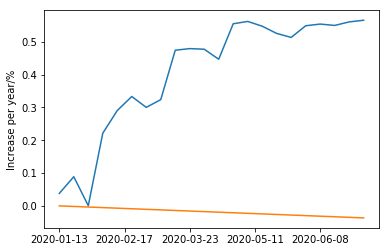

Final gain 0.5657382557586967
Market index -0.03668576901966513
For each transaction:
Max profit 0.22080833877769182
Max loss -0.0882520810828851
Rate of wins 0.6363636363636364
Info for each transaction [True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, True, False, True, True]


<Figure size 6000x4000 with 0 Axes>

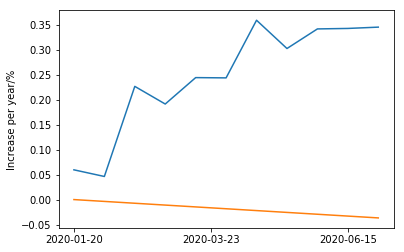

Final gain 0.3450111546654898
Market index -0.03668576901966513
For each transaction:
Max profit 0.18026455147503118
Max loss -0.056554529460527234
Rate of wins 0.6363636363636364
Info for each transaction [True, False, True, False, True, False, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

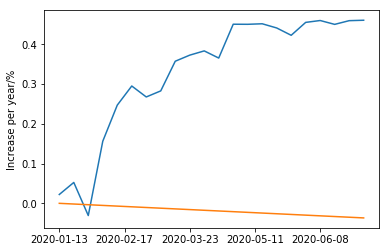

Final gain 0.4604158373111732
Market index -0.03668576901966513
For each transaction:
Max profit 0.1868665943718091
Max loss -0.0832070716268092
Rate of wins 0.6818181818181818
Info for each transaction [True, True, False, True, True, True, False, True, True, True, True, False, True, False, True, False, False, True, True, False, True, True]


<Figure size 6000x4000 with 0 Axes>

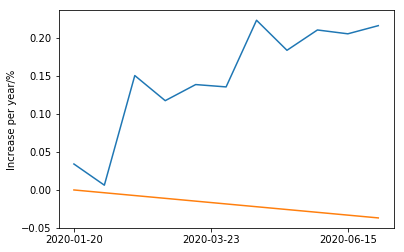

Final gain 0.21556842822050848
Market index -0.03668576901966513
For each transaction:
Max profit 0.1438390480239835
Max loss -0.03942993386822743
Rate of wins 0.5454545454545454
Info for each transaction [True, False, True, False, True, False, True, False, True, False, True]


<Figure size 6000x4000 with 0 Axes>

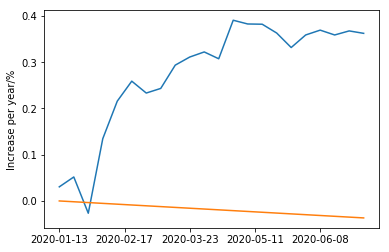

Final gain 0.36235551743853667
Market index -0.03668576901966513
For each transaction:
Max profit 0.16112551492314459
Max loss -0.07838988827150735
Rate of wins 0.5909090909090909
Info for each transaction [True, True, False, True, True, True, False, True, True, True, True, False, True, False, False, False, False, True, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

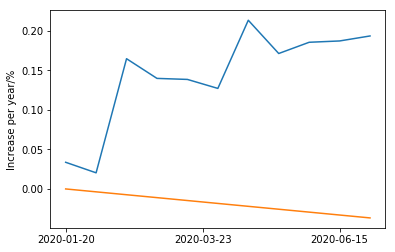

Final gain 0.19367501080713176
Market index -0.03668576901966513
For each transaction:
Max profit 0.14446615672789884
Max loss -0.042110203154151975
Rate of wins 0.5454545454545454
Info for each transaction [True, False, True, False, False, False, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

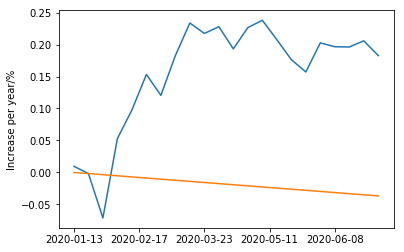

Final gain 0.18270669472301504
Market index -0.03668576901966513
For each transaction:
Max profit 0.1241006244123023
Max loss -0.06941161101437558
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, False, True, False, True, True, False, False, False, True, False, False, True, False]


<Figure size 6000x4000 with 0 Axes>

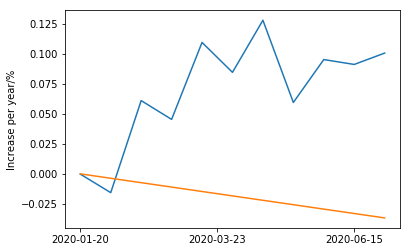

Final gain 0.10054783095544144
Market index -0.03668576901966513
For each transaction:
Max profit 0.07663433724689449
Max loss -0.06845214488445313
Rate of wins 0.45454545454545453
Info for each transaction [False, False, True, False, True, False, True, False, True, False, True]


<Figure size 6000x4000 with 0 Axes>

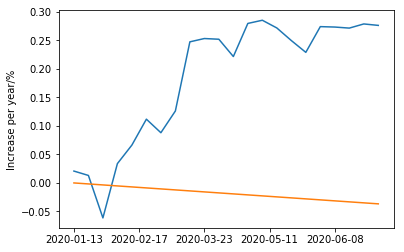

Final gain 0.276337983658686
Market index -0.03668576901966513
For each transaction:
Max profit 0.12129321117090948
Max loss -0.07449392784548307
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False]


<Figure size 6000x4000 with 0 Axes>

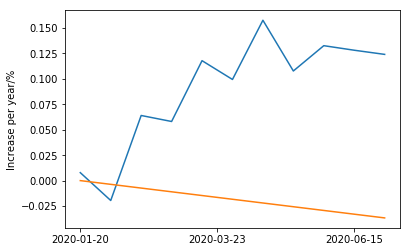

Final gain 0.12410699676175249
Market index -0.03668576901966513
For each transaction:
Max profit 0.08358957274488273
Max loss -0.0498892843297163
Rate of wins 0.45454545454545453
Info for each transaction [True, False, True, False, True, False, True, False, True, False, False]


In [4]:
times = f2020
tt = '2020上半年区间价格换手市值双低策略'
# idts = ['农林牧渔(2021)', '基础化工(2021)', '美容护理(2021)', '通信(2021)', '非银金融(2021)', '电力设备(2021)', '汽车(2021)', '电子(2021)']
prclst = [[110,120], [120,130], [130,140]]
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10)
start(DTBS, leap(times, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

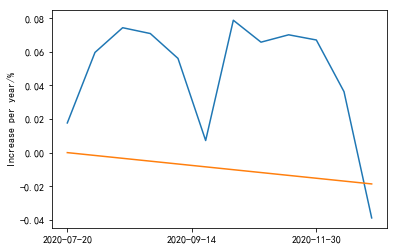

Final gain -0.03888218269633265
Market index -0.018645967595745706
For each transaction:
Max profit 0.0716109117463902
Max loss -0.07517463547892662
Rate of wins 0.4166666666666667
Info for each transaction [True, True, True, False, False, False, True, False, True, False, False, False]


In [74]:
times = s2020
tt = '2020下半年行业+双低1策略'
idts = ['家用电器(2021)', '基础化工(2021)', '建筑材料(2021)', '建筑装饰(2021)', '机械设备(2021)', '商贸零售(2021)', '计算机(2021)', '国防军工(2021)', '钢铁(2021)', '传媒(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

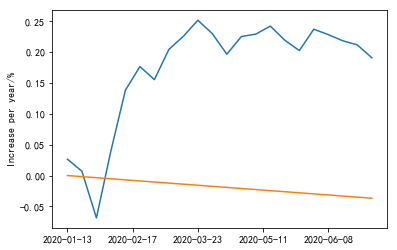

Final gain 0.19072155721360112
Market index -0.03668576901966513
For each transaction:
Max profit 0.10858020185749154
Max loss -0.07550163880298363
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, True, False, False, True, False, False, False, False]
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

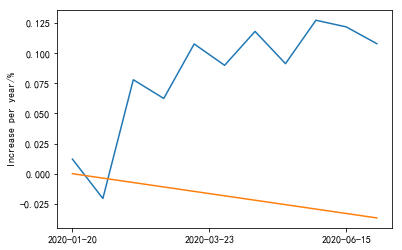

Final gain 0.10785367564562245
Market index -0.03668576901966513
For each transaction:
Max profit 0.09848957455179
Max loss -0.03260243052343497
Rate of wins 0.45454545454545453
Info for each transaction [True, False, True, False, True, False, True, False, True, False, False]
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

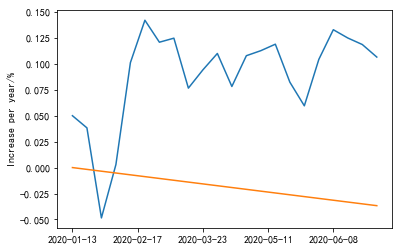

Final gain 0.10640624875881058
Market index -0.03668576901966513
For each transaction:
Max profit 0.09814393300736228
Max loss -0.08670607453347351
Rate of wins 0.5454545454545454
Info for each transaction [True, False, False, True, True, True, False, True, False, True, True, False, True, True, True, False, False, True, True, False, False, False]
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

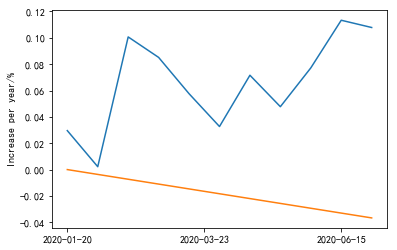

Final gain 0.10782688323002057
Market index -0.03668576901966513
For each transaction:
Max profit 0.09848957455179
Max loss -0.02755288985218828
Rate of wins 0.45454545454545453
Info for each transaction [True, False, True, False, False, False, True, False, True, True, False]
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

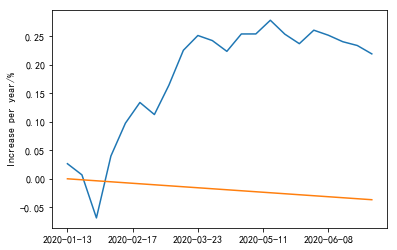

Final gain 0.21906874415270938
Market index -0.03668576901966513
For each transaction:
Max profit 0.10858020185749154
Max loss -0.07550163880298363
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, True, False, False, True, False, False, False, False]
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

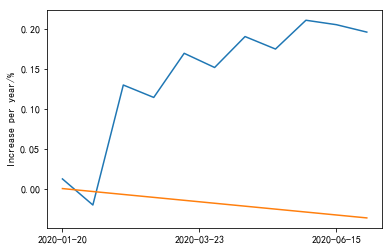

Final gain 0.19562106773670282
Market index -0.03668576901966513
For each transaction:
Max profit 0.15001379478626395
Max loss -0.03260243052343497
Rate of wins 0.45454545454545453
Info for each transaction [True, False, True, False, True, False, True, False, True, False, False]
Availble No. 6
Availble No. 6
Availble No. 5
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

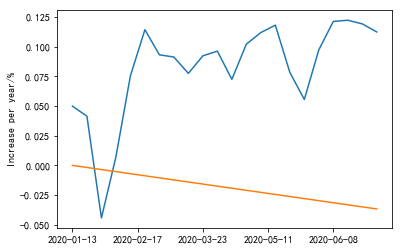

Final gain 0.11236259618073928
Market index -0.03668576901966513
For each transaction:
Max profit 0.06826642937730955
Max loss -0.08565803803300662
Rate of wins 0.5454545454545454
Info for each transaction [True, False, False, True, True, True, False, False, False, True, True, False, True, True, True, False, False, True, True, True, False, False]
Availble No. 6
Availble No. 5
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6
Availble No. 6


<Figure size 6000x4000 with 0 Axes>

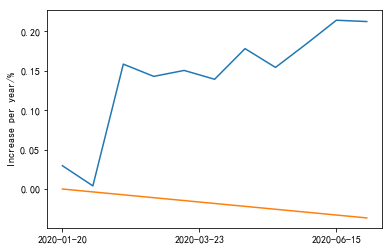

Final gain 0.21260040426459662
Market index -0.03668576901966513
For each transaction:
Max profit 0.1545513262978149
Max loss -0.02558599313060226
Rate of wins 0.5454545454545454
Info for each transaction [True, False, True, False, True, False, True, False, True, True, False]
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10


<Figure size 6000x4000 with 0 Axes>

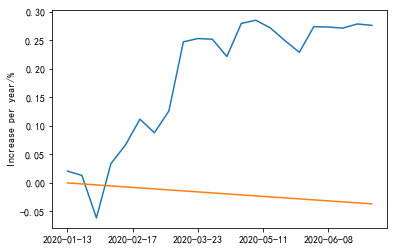

Final gain 0.276337983658686
Market index -0.03668576901966513
For each transaction:
Max profit 0.12129321117090948
Max loss -0.07449392784548307
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False]
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10
Availble No. 10


<Figure size 6000x4000 with 0 Axes>

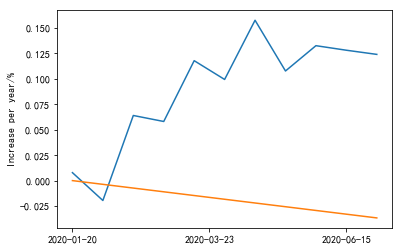

Final gain 0.12410699676175249
Market index -0.03668576901966513
For each transaction:
Max profit 0.08358957274488273
Max loss -0.0498892843297163
Rate of wins 0.45454545454545453
Info for each transaction [True, False, True, False, True, False, True, False, True, False, False]


In [66]:
times = s2020
tt = '2020下半年价格换手市值双低策略'
ap = []
aw = []
# idts = ['农林牧渔(2021)', '基础化工(2021)', '美容护理(2021)', '通信(2021)', '非银金融(2021)', '电力设备(2021)', '汽车(2021)', '电子(2021)']
prclst = [[110,120], [120,130], [130,140],]
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(times, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(times, 2), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)

<Figure size 6000x4000 with 0 Axes>

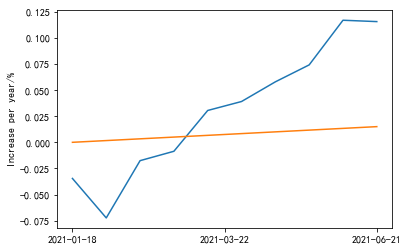

Final gain 0.11561820576913755
Market index 0.015012005248918965
For each transaction:
Max profit 0.05484111432488576
Max loss -0.0378116281745977
Rate of wins 0.7
Info for each transaction [False, False, True, True, True, True, True, True, True, False]


In [78]:
times = f2021
tt = '2021上半年行业+双低1策略'
idts = ['汽车(2021)', '交通运输(2021)', '农林牧渔(2021)', '煤炭(2021)', '有色金属(2021)', '商贸零售(2021)', '机械设备(2021)', '钢铁(2021)', '电力设备(2021)', '基础化工(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

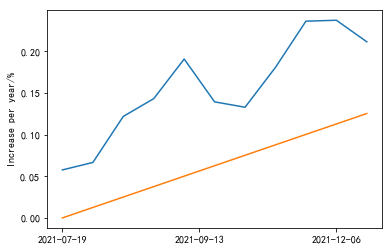

Final gain 0.21161860176829264
Market index 0.12542651022902263
For each transaction:
Max profit 0.05769468941709009
Max loss -0.05148466245896373
Rate of wins 0.7272727272727273
Info for each transaction [True, True, True, True, True, False, False, True, True, True, False]


In [82]:
times = s2021
tt = '2021下半年行业+双低1策略'
idts = ['电力设备(2021)', '有色金属(2021)', '交通运输(2021)', '钢铁(2021)', '通信(2021)', '汽车(2021)', '基础化工(2021)', '轻工制造(2021)', '国防军工(2021)', '医药生物(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

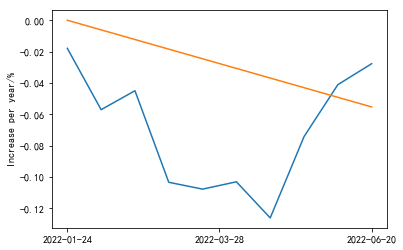

Final gain -0.02771398620067742
Market index -0.05531962600880805
For each transaction:
Max profit 0.05187580620427731
Max loss -0.058410995010825285
Rate of wins 0.5
Info for each transaction [False, False, True, False, False, True, False, True, True, True]


In [86]:
times = f2022_a
tt = '2022上半年行业+双低1策略'
idts = ['有色金属(2021)', '机械社保(2021)', '基础化工(2021)', '农林牧渔(2021)', '汽车(2021)', '交通运输(2021)', '国防军工(2021)', '医药生物(2021)', '通信(2021)', '电力设备(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

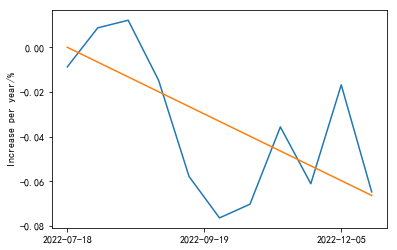

Final gain -0.06480076205907043
Market index -0.0663953989832808
For each transaction:
Max profit 0.04432527393593588
Max loss -0.04797967650083925
Rate of wins 0.45454545454545453
Info for each transaction [False, True, True, False, False, False, True, True, False, True, False]


In [93]:
times = s2022
tt = '2022下半年行业+双低1策略'
idts = ['有色金属(2021)', '农林牧渔(2021)', '汽车(2021)', '电力设备(2021)', '公用事业(2021)', '社会服务(2021)', '食品饮料(2021)', '医药生物(2021)', '轻工制造(2021)', '建筑材料(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

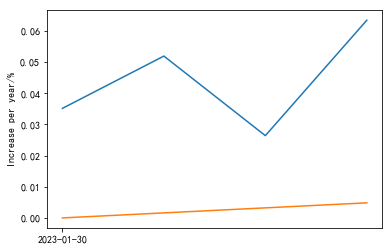

Final gain 0.06335634927377419
Market index 0.004831515304733499
For each transaction:
Max profit 0.036988518346078095
Max loss -0.025506789612667242
Rate of wins 0.75
Info for each transaction [True, True, False, True]


In [99]:
times = a2023
tt = '2023上半年行业+双低1策略'
idts = ['建筑材料(2021)', '建筑装饰(2021)', '国防军工(2021)', '计算机(2021)', '通信(2021)', '食品饮料(2021)', '社会服务(2021)', '纺织服饰(2021)', '交通运输(2021)', '轻工制造(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

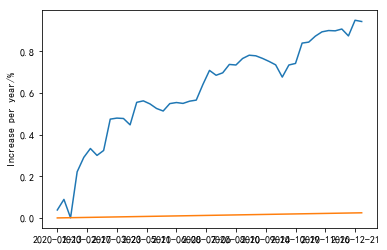

Final gain 0.9431847973386268
Market index 0.02455815349311315
For each transaction:
Max profit 0.22080833877769182
Max loss -0.0882520810828851
Rate of wins 0.6170212765957447
Info for each transaction [True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, False, False, False, False, False, True, True, True, True, True, True, True, False, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

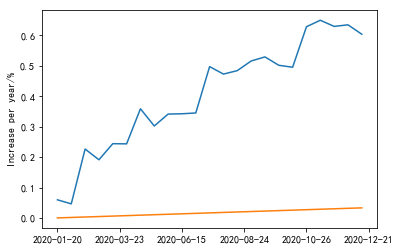

Final gain 0.6039397702877239
Market index 0.033045622827152045
For each transaction:
Max profit 0.18026455147503118
Max loss -0.056554529460527234
Rate of wins 0.6086956521739131
Info for each transaction [True, False, True, False, True, False, True, False, True, True, True, True, False, True, True, True, False, False, True, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

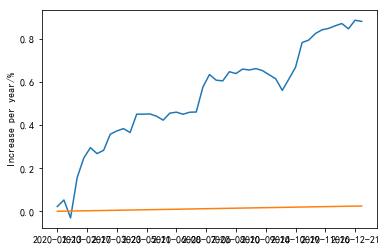

Final gain 0.8806601040512592
Market index 0.02455815349311315
For each transaction:
Max profit 0.1868665943718091
Max loss -0.0832070716268092
Rate of wins 0.6382978723404256
Info for each transaction [True, True, False, True, True, True, False, True, True, True, True, False, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

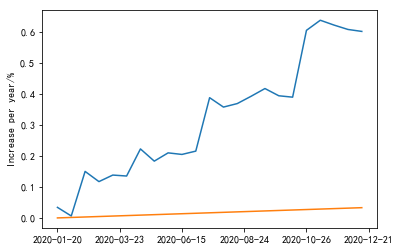

Final gain 0.6018646371864219
Market index 0.033045622827152045
For each transaction:
Max profit 0.21563486225470407
Max loss -0.03942993386822743
Rate of wins 0.5217391304347826
Info for each transaction [True, False, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, False, True, True, False, False, False]


<Figure size 6000x4000 with 0 Axes>

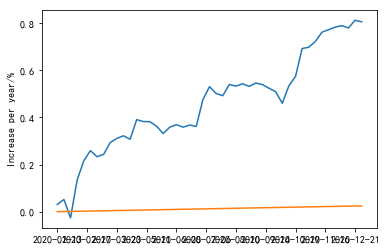

Final gain 0.8058798993394153
Market index 0.02455815349311315
For each transaction:
Max profit 0.16112551492314459
Max loss -0.07838988827150735
Rate of wins 0.5957446808510638
Info for each transaction [True, True, False, True, True, True, False, True, True, True, True, False, True, False, False, False, False, True, True, False, True, False, True, True, False, False, True, False, True, False, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

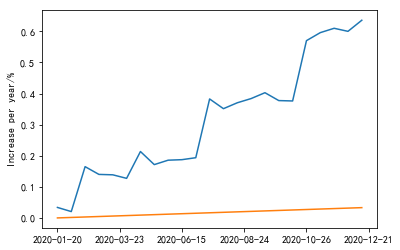

Final gain 0.6358370313935642
Market index 0.033045622827152045
For each transaction:
Max profit 0.1939576086088132
Max loss -0.042110203154151975
Rate of wins 0.6086956521739131
Info for each transaction [True, False, True, False, False, False, True, False, True, True, True, True, False, True, True, True, False, False, True, True, True, False, True]


<Figure size 6000x4000 with 0 Axes>

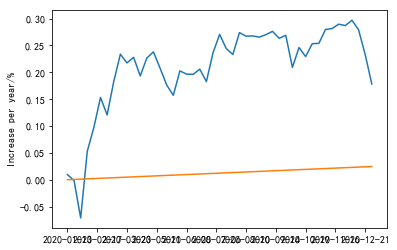

Final gain 0.1781694817532214
Market index 0.02455815349311315
For each transaction:
Max profit 0.1241006244123023
Max loss -0.06941161101437558
Rate of wins 0.5319148936170213
Info for each transaction [True, False, False, True, True, True, False, True, True, False, True, False, True, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, True, False, True, True, False, True, False, True, False, True, True, True, True, True, False, True, False, False, False]


<Figure size 6000x4000 with 0 Axes>

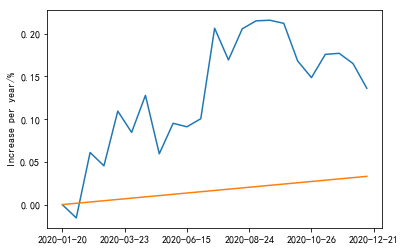

Final gain 0.13620443204500812
Market index 0.033045622827152045
For each transaction:
Max profit 0.10597320498545319
Max loss -0.06845214488445313
Rate of wins 0.4782608695652174
Info for each transaction [False, False, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False]


<Figure size 6000x4000 with 0 Axes>

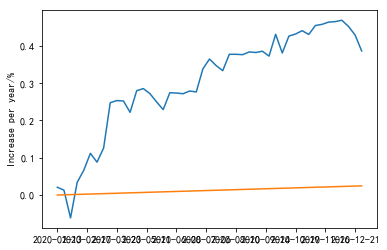

Final gain 0.38624493146642147
Market index 0.02455815349311315
For each transaction:
Max profit 0.12129321117090948
Max loss -0.07449392784548307
Rate of wins 0.5319148936170213
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, False, True, False, True, False, True, False, True, True, True, False, True, True, True, True, True, False, False, False]


<Figure size 6000x4000 with 0 Axes>

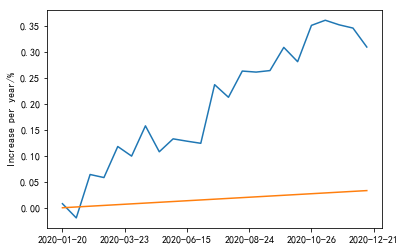

Final gain 0.3094532217920432
Market index 0.033045622827152045
For each transaction:
Max profit 0.11288621346592533
Max loss -0.0498892843297163
Rate of wins 0.4782608695652174
Info for each transaction [True, False, True, False, True, False, True, False, True, False, False, True, False, True, False, True, True, False, True, True, False, False, False]


In [30]:
times = a2020
tt = '2020全年区间价格[110,120],[120,130],[130,140]与双低策略'
ap = []
aw = []
prclst = [[110,120], [120,130], [130,140]]
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 2, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 2, 0, 'trt', 2, 10)
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 3, 0, 'trt', 2, 10)
start(DTBS, leap(times, 1), [], 0, 1, prclst, 1, 4, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 1, prclst, 1, 4, 0, 'trt', 2, 10)
start(DTBS, leap(times, 1), [], 0, 0, prclst, 1, 5, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 0, prclst, 1, 5, 0, 'trt', 2, 10)
start(DTBS, leap(times, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10)
start(DTBS, leap(times, 2), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

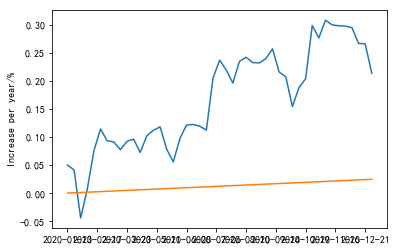

Final gain 0.2135063866263855
Market index 0.02455815349311315
For each transaction:
Max profit 0.09470134526152289
Max loss -0.08565803803300662
Rate of wins 0.46808510638297873
Info for each transaction [True, False, False, True, True, True, False, False, False, True, True, False, True, True, True, False, False, True, True, True, False, False, True, True, False, False, True, True, False, False, True, True, False, False, False, True, True, True, False, True, False, False, False, False, False, False, False]


<Figure size 6000x4000 with 0 Axes>

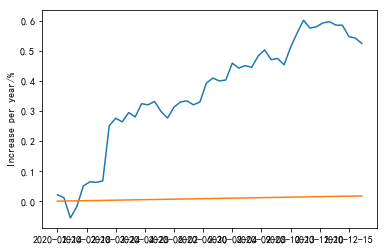

Final gain 0.5249962813002754
Market index 0.017371034169149528
For each transaction:
Max profit 0.18353385363734828
Max loss -0.06750609694422278
Rate of wins 0.5833333333333334
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, True, False, True, False, True, False, False, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, False, True, False, True, True, True, False, True, True, True, False, False, False, False, False]
Nothing Satisfies! 120 bl


<Figure size 6000x4000 with 0 Axes>

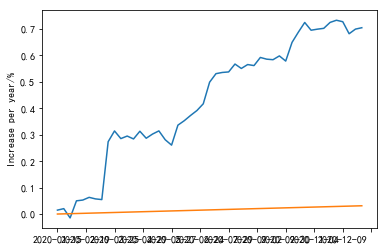

Final gain 0.7047791201561
Market index 0.03122955223044589
For each transaction:
Max profit 0.21893767875398878
Max loss -0.04549674253601441
Rate of wins 0.673469387755102
Info for each transaction [True, True, False, True, True, True, False, False, True, True, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, False, False, True, False, True, True, True, False, True, True, True, True, False, False, True, True]


<Figure size 6000x4000 with 0 Axes>

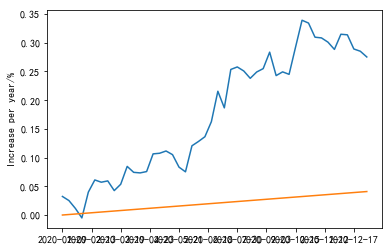

Final gain 0.2752706398915389
Market index 0.04087750990850039
For each transaction:
Max profit 0.06691896723969083
Max loss -0.040834815657765484
Rate of wins 0.5
Info for each transaction [True, False, False, False, True, True, False, True, False, True, True, False, False, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, False, False, True, True, True, False, True, False, True, True, False, False, False, False, False, True, False, False, False, False]


<Figure size 6000x4000 with 0 Axes>

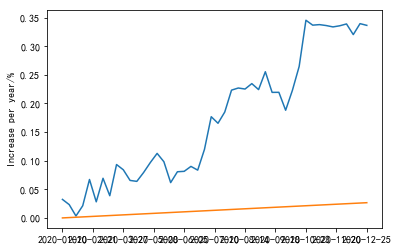

Final gain 0.3365016349125518
Market index 0.02659595922842357
For each transaction:
Max profit 0.08073310487395433
Max loss -0.039027502323065594
Rate of wins 0.5652173913043478
Info for each transaction [True, False, False, True, True, False, True, False, True, False, False, False, True, True, True, False, False, True, True, True, False, True, True, False, True, True, True, False, True, False, True, False, True, False, True, True, True, False, True, False, False, True, True, False, True, False]


<Figure size 6000x4000 with 0 Axes>

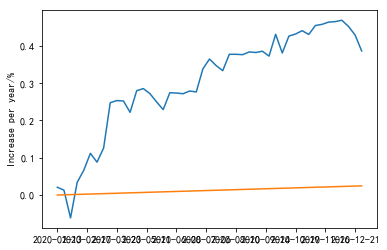

Final gain 0.38624493146642147
Market index 0.02455815349311315
For each transaction:
Max profit 0.12129321117090948
Max loss -0.07449392784548307
Rate of wins 0.5319148936170213
Info for each transaction [True, False, False, True, True, True, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, False, True, False, True, False, True, False, True, True, True, False, True, True, True, True, True, False, False, False]


<Figure size 6000x4000 with 0 Axes>

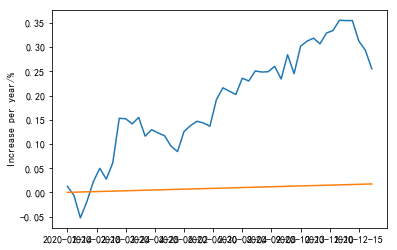

Final gain 0.2552003687857754
Market index 0.017371034169149528
For each transaction:
Max profit 0.09192703660411959
Max loss -0.0465788301636678
Rate of wins 0.5
Info for each transaction [True, False, False, True, True, True, False, True, True, False, False, True, False, True, False, False, False, False, True, True, True, False, False, True, True, False, False, True, False, True, False, True, True, False, True, False, True, True, True, False, True, True, True, False, False, False, False, False]


<Figure size 6000x4000 with 0 Axes>

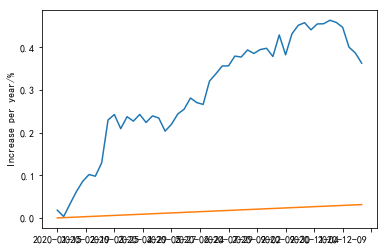

Final gain 0.36258006616570765
Market index 0.03122955223044589
For each transaction:
Max profit 0.10034693058959765
Max loss -0.04659187365534526
Rate of wins 0.6122448979591837
Info for each transaction [True, False, True, True, True, True, False, True, True, True, False, True, False, True, False, True, False, False, True, True, True, True, False, False, True, True, True, True, True, False, True, False, True, True, False, True, False, True, True, True, False, True, True, True, False, False, False, False, False]


<Figure size 6000x4000 with 0 Axes>

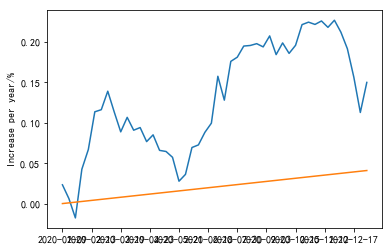

Final gain 0.14987058181653123
Market index 0.04087750990850039
For each transaction:
Max profit 0.06025202786678571
Max loss -0.04355491497495269
Rate of wins 0.5833333333333334
Info for each transaction [True, False, False, True, True, True, True, True, False, False, True, False, True, False, True, False, False, False, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, False, True, True, True, False, True, False, True, False, False, False, False, True]


<Figure size 6000x4000 with 0 Axes>

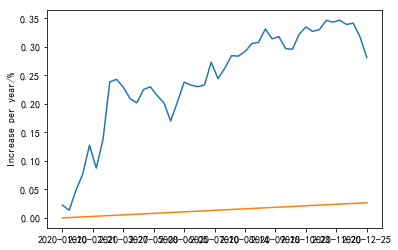

Final gain 0.2811906378988789
Market index 0.02659595922842357
For each transaction:
Max profit 0.10105290135910186
Max loss -0.040058371131286866
Rate of wins 0.5652173913043478
Info for each transaction [True, False, True, True, True, False, True, True, True, False, False, False, True, True, False, False, False, True, True, False, False, True, True, False, True, True, False, True, True, True, True, False, True, False, False, True, True, False, True, True, False, True, False, True, False, False]


In [105]:
times = f2020_1
tt = '2020周一到周五'
ap = []
aw = []
# idts = ['农林牧渔(2021)', '基础化工(2021)', '美容护理(2021)', '通信(2021)', '非银金融(2021)', '电力设备(2021)', '汽车(2021)', '电子(2021)']
prclst = [[110,120], [120,130]]
start(DTBS, leap(a2020_1, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2020_2, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2020_3, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2020_4, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2020_5, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2020_1, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2020_2, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2020_3, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2020_4, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2020_5, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)

<Figure size 6000x4000 with 0 Axes>

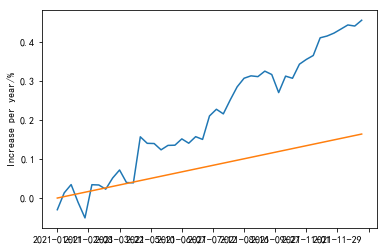

Final gain 0.45589268557184476
Market index 0.16408571513833511
For each transaction:
Max profit 0.11799728645505098
Max loss -0.04632456322154558
Rate of wins 0.6
Info for each transaction [False, True, True, False, False, True, False, False, True, True, False, False, True, False, False, False, True, True, True, False, True, False, True, True, False, True, True, True, True, False, True, False, False, True, False, True, True, True, True, True, True, True, True, False, True]


<Figure size 6000x4000 with 0 Axes>

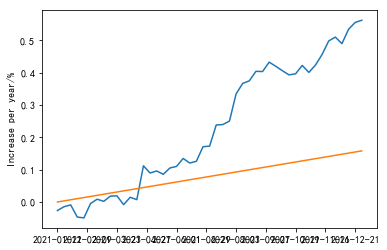

Final gain 0.5620493924346873
Market index 0.1580542238753199
For each transaction:
Max profit 0.10444914393184541
Max loss -0.03761403508771924
Rate of wins 0.6808510638297872
Info for each transaction [False, True, True, False, False, True, True, False, True, True, False, True, False, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, True, True, True, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

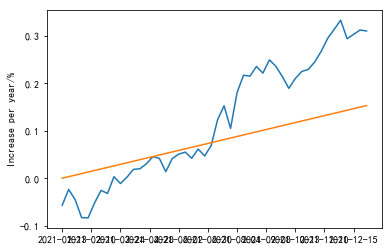

Final gain 0.31059152735297274
Market index 0.15326684214559158
For each transaction:
Max profit 0.07527035456221144
Max loss -0.05726163487339902
Rate of wins 0.625
Info for each transaction [False, True, False, False, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, False, True, False, True, True, True, False, True, True, False, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, True, True, False]


<Figure size 6000x4000 with 0 Axes>

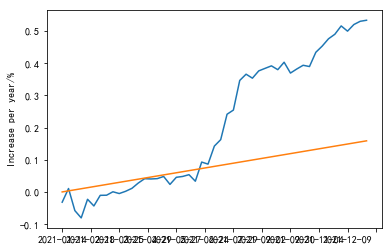

Final gain 0.5334908353316724
Market index 0.15877670984980574
For each transaction:
Max profit 0.09201937220532769
Max loss -0.06866058496175637
Rate of wins 0.7142857142857143
Info for each transaction [False, True, False, False, True, False, True, True, True, False, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, False, True, False, True, True, False, True, True, True, True, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

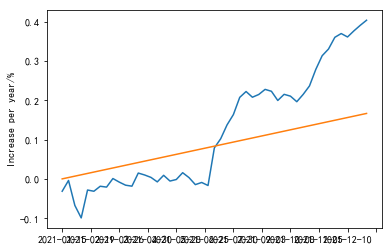

Final gain 0.4039497582265314
Market index 0.16663596579289927
For each transaction:
Max profit 0.09574259618989191
Max loss -0.06362820998960385
Rate of wins 0.5714285714285714
Info for each transaction [False, True, False, False, True, False, True, False, True, False, False, False, True, False, False, False, True, False, True, True, False, False, True, False, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

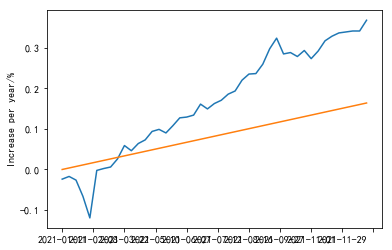

Final gain 0.36835563279731487
Market index 0.16408571513833511
For each transaction:
Max profit 0.11722893668957818
Max loss -0.05323493234932343
Rate of wins 0.7555555555555555
Info for each transaction [False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, True, True, True, True, False, True]


<Figure size 6000x4000 with 0 Axes>

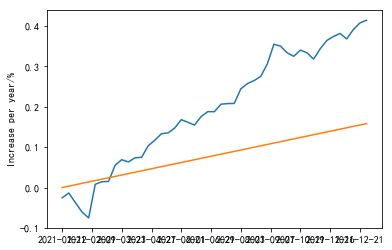

Final gain 0.4135925216569073
Market index 0.1580542238753199
For each transaction:
Max profit 0.08309854535131096
Max loss -0.025408882198919788
Rate of wins 0.7021276595744681
Info for each transaction [False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, False, False, True, True, True, True, False, True, True, True]


<Figure size 6000x4000 with 0 Axes>

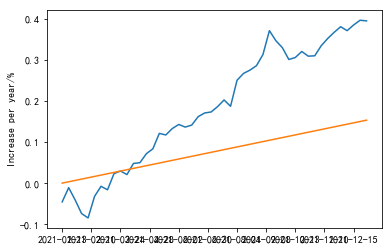

Final gain 0.39496200541313203
Market index 0.15326684214559158
For each transaction:
Max profit 0.06339117519374496
Max loss -0.04570465070717255
Rate of wins 0.6875
Info for each transaction [False, True, False, False, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, True, False, True, True, False]


<Figure size 6000x4000 with 0 Axes>

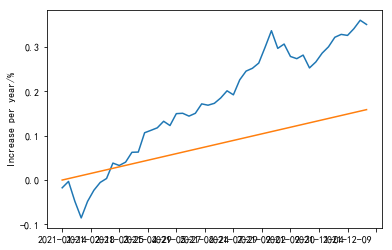

Final gain 0.35080427423201943
Market index 0.15877670984980574
For each transaction:
Max profit 0.043579192257771106
Max loss -0.04484363535088991
Rate of wins 0.7142857142857143
Info for each transaction [False, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, False, True, True, True, True, True, True, False, True, False, False, True, False, True, True, True, True, True, False, True, True, False]


<Figure size 6000x4000 with 0 Axes>

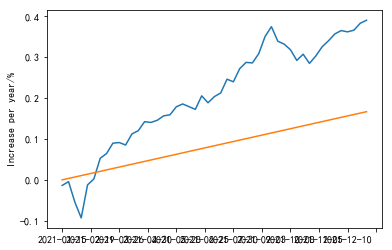

Final gain 0.39005122753395877
Market index 0.16663596579289927
For each transaction:
Max profit 0.08066675669056891
Max loss -0.05013844520044043
Rate of wins 0.673469387755102
Info for each transaction [False, True, False, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, False, False, True, False, True, True, True, False, True, True, False, True, True, True, False, False, False, False, True, False, True, True, True, True, True, False, True, True, True]


In [111]:
times = f2020_1
tt = '2021周一到周五'
ap = []
aw = []
# idts = ['农林牧渔(2021)', '基础化工(2021)', '美容护理(2021)', '通信(2021)', '非银金融(2021)', '电力设备(2021)', '汽车(2021)', '电子(2021)']
prclst = [[110,120], [120,130]]
start(DTBS, leap(a2021_1, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2021_2, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2021_3, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2021_4, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2021_5, 1), [], 0, 1, prclst, 1, 3, 1, 'trt', 2, 10, 1, 'bl', 0, 7)
start(DTBS, leap(a2021_1, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2021_2, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2021_3, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2021_4, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)
start(DTBS, leap(a2021_5, 1), [], 0, 0, prclst, 1, 10, 0, 'trt', 2, 10, 0, 'bl', 0, 7)

In [112]:
# plot together


# from pylab import *
# from matplotlib.font_manager import FontProperties  
# import matplotlib.pyplot as plt 

# font = FontProperties(fname=r"simsun.ttf", size=14)  
# matplotlib.rcParams['axes.unicode_minus'] =False
# mpl.rcParams['font.sans-serif'] = ['SimHei']

# # times = a2023

# tick_spacing = 4
# plt.figure(figsize=(80,60))

# fig, ax = plt.subplots(1,1)
# plt.plot(leap(times, 1)[1:], ap[0],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[1],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[2],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[3],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[4],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[5],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[6],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[7],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[8],linestyle='dotted', label='价格双低3单周')
# plt.plot(leap(times, 1)[1:], ap[9],linestyle='dotted', label='价格双低3单周')
# # plt.plot(leap(times, 1)[1:], ap[0],linestyle='dotted', label='价格双低3单周')

# # plt.plot(leap(times, 2)[1:], ap[1],linestyle='dotted', label='价格双低3双周')
# # plt.plot(leap(times, 1)[1:], ap[2],linestyle='dashed', label='价格换手双低3单周')
# # plt.plot(leap(times, 2)[1:], ap[3],linestyle='dashed', label='价格换手双低3双周')
# # plt.plot(leap(times, 1)[1:], ap[4],linestyle='dashed', label='价格市值双低3单周')
# # plt.plot(leap(times, 2)[1:], ap[5],linestyle='dashed', label='价格市值双低3双周')
# # plt.plot(leap(times, 1)[1:], ap[6],linestyle='dashdot', label='价格换手市值双低3单周')
# # plt.plot(leap(times, 2)[1:], ap[7],linestyle='dashdot', label='价格换手市值双低3双周')
# # plt.plot(leap(times, 1)[1:], ap[8],linestyle='dotted', label='双低10单周')
# # plt.plot(leap(times, 2)[1:], ap[9],linestyle='dotted', label='双低10双周')
# # plt.plot(leap(times, 4)[1:], ap[2],linestyle='dashdot',label='每月换仓')
# # plt.plot(leap(times, 4)[1:], ap[2],linestyle='solid',label='每月换仓')
# i_x = [leap(times, 1)[1], leap(times, 1)[-1]]
# #     print(market['zi'][days[-1]], market['zi'][days[0]])

# market_gain = (DTBS['C']['zi'][leap(times, 1)[-1]]-DTBS['C']['zi'][leap(times, 1)[0]])/(DTBS['C']['zi'][leap(times, 1)[0]])
# i_y = [0, market_gain]
# plt.plot(i_x, i_y, linestyle='solid', label='市场')

# plt.legend(fontsize = 'x-small')

# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# plt.ylabel('收益率/%')

# plt.title(tt)
# plt.savefig(tt, dpi=300)
# plt.show()

with open('log.txt','a') as f:
    print(tt, file=f)
    print("市场收益：", market_gain, file=f)
#     print("每周换仓收益：", ap[0][-1], file=f)
#     print("每两周换仓收益：", ap[1][-1], file=f)
#     print("每月换仓收益：", ap[2][-1], file=f)
    print(ap[0][-1], file=f)
    print(ap[1][-1], file=f)
    print(ap[2][-1], file=f)
    print(ap[3][-1], file=f)
    print(ap[4][-1], file=f)
    print(ap[5][-1], file=f)
    print(ap[6][-1], file=f)
    print(ap[7][-1], file=f)
    print(ap[8][-1], file=f)
    print(ap[9][-1], file=f)
#     print(ap[2][-1], file=f)
#     print(ap[0][-1], ap[1][-1], file=f)
    print("\n", file=f)
    


In [160]:
ap

[[0.03803676274088006,
  0.08885253294736886,
  0.0006004518644837642,
  0.22140879064217558,
  0.2905692589163197,
  0.3333168021220127,
  0.300218425576984,
  0.32379638970425756,
  0.4743391222505493,
  0.47931053125677975,
  0.477415439093637,
  0.44694782022188495,
  0.5550229251215392,
  0.5621153036862608,
  0.5475753763588516,
  0.5255115030786227,
  0.5134072468008835,
  0.5489321687040353,
  0.5540697947674051,
  0.5499194729278264,
  0.5606605926392727,
  0.5657382557586967],
 [0.059523148037900445,
  0.04622274333181295,
  0.22648729480684412,
  0.19117044977833333,
  0.24402460399232023,
  0.2435004483804714,
  0.35880061860523327,
  0.302246089144706,
  0.34144010644589096,
  0.34240585605507246,
  0.3450111546654898],
 [0.022223146883296924,
  0.05248977116878789,
  -0.030717300458021304,
  0.1561492939137878,
  0.24691993987558986,
  0.2950394159214584,
  0.2675040019289035,
  0.28275963184413117,
  0.357335475994132,
  0.372642085342027,
  0.3833215979417761,
  0.36531

In [105]:
DTBS['A']['123019.SZ'][]

{'2017-01-03': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-04': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-05': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-06': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-09': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-10': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-11': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-12': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-13': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-16': {'cp

In [108]:
2 in range(0,10)

True

In [164]:
DTBS['C']['zi']['2023-03-20'] = np.float64(DTBS['C']['zi']['2023-03-20'])
DTBS['C']['zi']['2023-03-21'] = np.float64(DTBS['C']['zi']['2023-03-21'])
DTBS['C']['zi']['2023-03-22'] = np.float64(DTBS['C']['zi']['2023-03-22'])

In [165]:
# save
f_save = open(DTBS_path, 'wb')
pickle.dump(DTBS, f_save)
f_save.close()


In [161]:
type(np.float64(411.2))

numpy.float64

In [97]:
DTBS['A']['123019.SZ']['2020-03-26']

{'cpr': nan,
 'dp': nan,
 'bl': nan,
 'trt': nan,
 'ytm': nan,
 'yl': nan,
 'ia': 0,
 'dl': 999}

In [124]:
DTBS['B']['123035.SZ']

{'cn': '利德转债',
 'ipo': '2019-12-09',
 'sc': '300296.SZ',
 'sn': '利亚德',
 'cat1': '电子(2021)',
 'cat2': '光学光电子(2021)',
 'dld': '2046-01-01'}

In [123]:
DTBS['A']['123035.SZ']


{'2017-01-03': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-04': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-05': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-06': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-09': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-10': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-11': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-12': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-13': {'cpr': nan,
  'dp': nan,

In [37]:
DTBS['A']['123035.SZ']

{'2017-01-03': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-04': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-05': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-06': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-09': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-10': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-11': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-12': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999,
  'ia': 0},
 '2017-01-13': {'cpr': nan,
  'dp': nan,

In [ ]:
print(len())